In [1]:
import glob
import numpy as np
import astropy.units as u
from astropy.time import Time
from astropy.constants import c

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

%matplotlib inline

In [18]:
import dynspectools as dtools
import normsspectools as ns

# Load our dynamic spectrum

## If you are instead starting directly from a dynamic spectrum (.dspec), go to "Let's measure the size of scintles"  use dtools.read_psrflux()

The archive is a data cube of dimensions [time, pol, frequency, phase].  Typical pulsar diagnostic plots show t vs. phase and phase vs. frequency.  

We are after the "dynamic spectrum", which is simply the time vs. frequency.

For this tutotial we will ignore polarization.  The pols are ordered XX*, YY*, Re(XY*), Im(XY*) (or L and R if feeds are circular), so we sum the 0 and 1 pols to form the total intensity.



Text(0, 0.5, 'frequency (bins)')

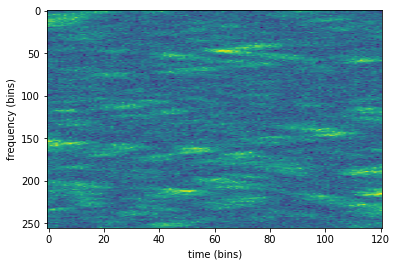

In [96]:
"""
If you are reading from a .dspec file, the above steps can be skipped.  
Use this function to read in your dynspec

"""

fname = 'data/simpsr_59441.26527528103.dynspec'
dynspec, dserr, T, F, psrname = dtools.read_psrflux(fname)

plt.imshow(dynspec.T, aspect='auto')
plt.xlabel('time (bins)')
plt.ylabel('frequency (bins)')

In [97]:
"""
Look at details of the observation
"""

t0 = Time(T[0], format='mjd')
tend = Time(T[-1], format='mjd')
Tobs = tend.unix - t0.unix
BW = F[-1] - F[0]

print("data shape is {0}".format(dynspec.shape))

print("Start time is {0}".format(t0.isot))

print("Observation Length is {0}s".format(Tobs) )

print("Frequency range is {0} - {1}".format(min(F), max(F)) )

data shape is (121, 256)
Start time is 2021-08-15T06:22:59.784
Observation Length is 14399.999999761581s
Frequency range is 1400.0 MHz - 1449.8046875 MHz


# Let's measure the characteristic time and frequency size of scintles

We will do this using the 2D Autocorrelation Function

To do this, we FFT, multiply, and iFFT the dynamic spectrum 

Remember convolution theorem - the dynspecs are multiplied in Fourier space, so they are convolved when IFTed


df = 0.5774249894996306 +- 0.020479703128418753 MHz
dt = 993.8248377002781 +- 8.220090764673884, seconds


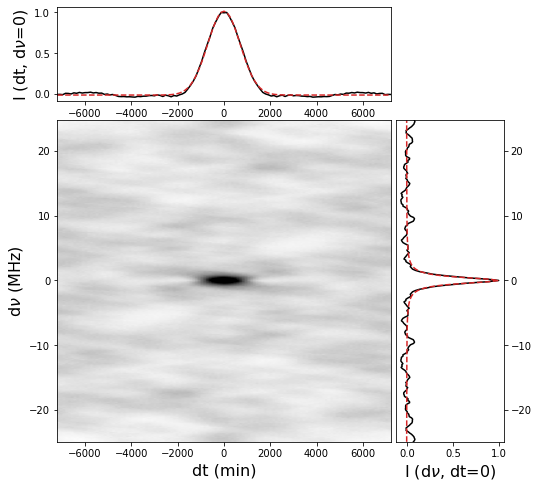

In [98]:
from scipy.optimize import curve_fit

def Gaussian(x, sigma, A, C):
    return A*np.exp( -x**2 / (2*sigma**2) ) + C

def Lorentzian(x, gamma, A, C):
    return A* ( (0.5*gamma) / ( x**2 + (0.5*gamma)**2 ) ) + C

ccorr = np.fft.ifft2( np.fft.fft2(dynspec) * np.fft.fft2(dynspec).conj() )
# Im values are 0 anyways, so take the absolute value or real values
ccorr = abs(ccorr)

# Take slice through center of cross-correlation along frequency axis
# Ignoring zero component with noise-noise correlation
ccorr_f = ccorr[1] + ccorr[-1]
ccorr_f -= np.median(ccorr_f)
ccorr_f /= np.max(ccorr_f)
ccorr_f = np.fft.fftshift(ccorr_f)

# Take slice through center of cross-correlation along time axis
# Ignoring zero component with noise-noise correlation
ccorr_t = ccorr[:,1] + ccorr[:,-1]
ccorr_t -= np.median(ccorr_t)
ccorr_t /= np.max(ccorr_t)
ccorr_t = np.fft.fftshift(ccorr_t)

# Get the correct units
BW = (max(F) - min(F)).value
df_axis = np.linspace(-BW/2., BW/2., len(F), endpoint=False)
dt_axis = np.linspace(-Tobs/2., Tobs/2., len(T), endpoint=True)

# Fit the slices in frequency and time with a Gaussian
# p0 values are just a starting guess
p0 = [5., 1, 0]
popt, pcov = curve_fit(Lorentzian, df_axis, ccorr_f, p0=p0)

nuscint = abs(popt[0])
nuscint_err = np.sqrt(pcov[0,0])

#fscint =  np.sqrt(2*np.log(2)) * nuscint
#fscinterr =  np.sqrt(2*np.log(2)) * nuscint_err 
fscint = nuscint / 2.
fscinterr = nuscint_err / 2.

pT = [1000., 1, 0]
poptT, pcovT = curve_fit(Gaussian, dt_axis, ccorr_t, p0=pT)
tscint = np.sqrt(2) * abs(poptT[0])
tscinterr = np.sqrt(2) * np.sqrt(pcovT[0,0])

# Find nice vmax, vmin values for plotting
vmax = np.mean(ccorr) + 10*np.std(ccorr)
vmin = np.mean(ccorr) - 3*np.std(ccorr)


plt.figure(figsize=(8,8))

ax1 = plt.subplot2grid((4, 4), (1, 0), colspan=3, rowspan=3)
ax2 = plt.subplot2grid((4, 4), (1, 3), rowspan=3)
ax3 = plt.subplot2grid((4, 4), (0, 0), colspan=3)

plt.subplots_adjust(wspace=0.05)

ax1.imshow(np.fft.fftshift(ccorr).T, aspect='auto', origin='lower',
          extent=[min(dt_axis), max(dt_axis), min(df_axis), max(df_axis)],
          vmax=vmax, vmin=vmin, cmap='Greys')

ax1.set_xlabel('dt (min)', fontsize=16)
ax1.set_ylabel(r'd$\nu$ (MHz)', fontsize=16)

ax2.plot( ccorr_f, df_axis, color='k')
ax2.plot(Lorentzian(df_axis, *popt), df_axis, color='tab:red',
        linestyle='--')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel(r'I (d$\nu$, dt=0)', fontsize=16)
ax2.set_ylim(min(df_axis), max(df_axis) )

ax3.plot( dt_axis, ccorr_t, color='k')
ax3.plot( dt_axis, Gaussian(dt_axis, *poptT), color='tab:red',
          linestyle='--')
ax3.set_ylabel(r'I (dt, d$\nu$=0)', fontsize=16)
ax3.set_xlim(min(dt_axis), max(dt_axis))

print("df = {0} +- {1} MHz".format(fscint, fscinterr))
print("dt = {0} +- {1}, seconds".format(tscint, tscinterr))


# Look at Secondary Spectrum

The secondary spectrum is the squared modulus of the 2D FFT of the dynamic spectrum

It expresses the power in terms of the time delay and fringe rate between all pairs of interfering images

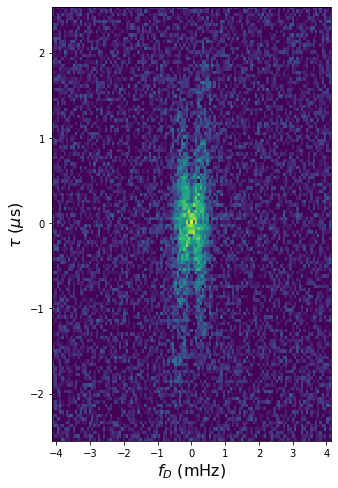

In [99]:
# Plotting choices, fiddle to look good
bintau = 2
binft = 1
vm = 3.
xlim = 0
ylim = 0

df = (F[1] - F[0])
dt = (T[1] - T[0]).to(u.s)

CS = np.fft.fft2(dynspec)
S = np.abs(np.fft.fftshift(CS))**2.0    

Sb = S.reshape(-1,S.shape[1]//bintau, bintau).mean(-1)
if binft > 1:
    nftbin = Sb.shape[0]//binft
    print(Sb.shape)
    Sb = Sb[:binft*nftbin].reshape(nftbin, binft, -1).mean(1)
Sb = np.log10(Sb)

# Calculate the conjugate frequencies (time delay, fringe rate), only used for plotting
ft = np.fft.fftfreq(S.shape[0], dt)
ft = np.fft.fftshift(ft.to(u.mHz).value)

tau = np.fft.fftfreq(S.shape[1], df)
tau = np.fft.fftshift(tau.to(u.microsecond).value)    

slow = np.median(Sb)-0.2
shigh = slow + vm

# Not the nicest, have a set of different plots it can produce
plt.figure(figsize=(5,8))

# Plot Secondary spectrum
plt.imshow(Sb.T, aspect='auto', vmin=slow, vmax=shigh, origin='lower',
           extent=[min(ft), max(ft), min(tau), max(tau)], interpolation='nearest',
          cmap='viridis')
plt.xlabel(r'$f_{D}$ (mHz)', fontsize=16)
plt.ylabel(r'$\tau$ ($\mu$s)', fontsize=16) 

if xlim:
    plt.xlim(-xlim, xlim)
if ylim:
    plt.ylim(-ylim, ylim)

# All together, single command

df = 0.7140464559130161 +- 0.19746062349288987 MHz
dt = 947.8486529850047 +- 7.233527830472237, seconds


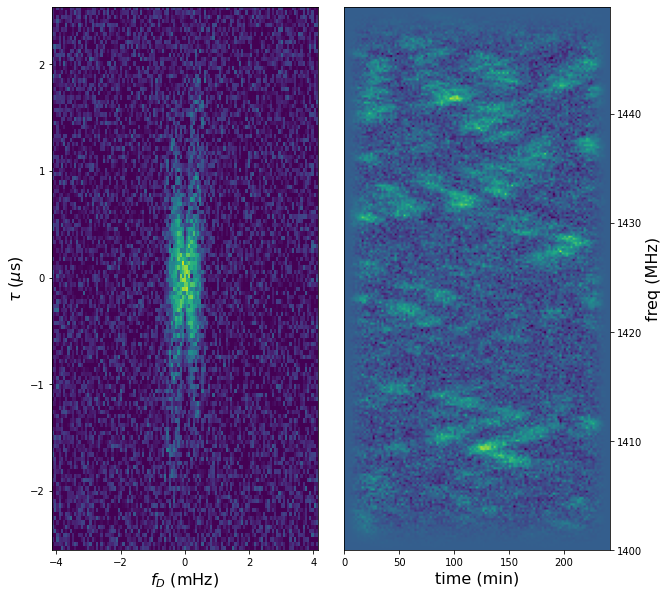

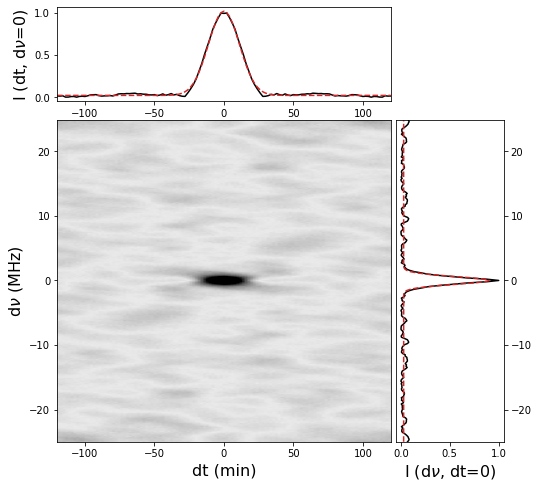

In [100]:
CS, ft, tau = dtools.plot_secspec(dynspec, F.value, dt=dt, binft=binft,
                       bintau=bintau, vm=3.)

ccorr, fscint, fscinterr, tscint, tscinterr = dtools.Gaussfit(dynspec, df, dt)

print("df = {0} +- {1} MHz".format(fscint, fscinterr))
print("dt = {0} +- {1}, seconds".format(tscint, tscinterr))

# Measuring arc curvatures: overplotting parabolae, or using "Normalized Secondary Spectrum"

13.778276707874543 km / (kpc(1/2) s)


(-2.56, 2.54)

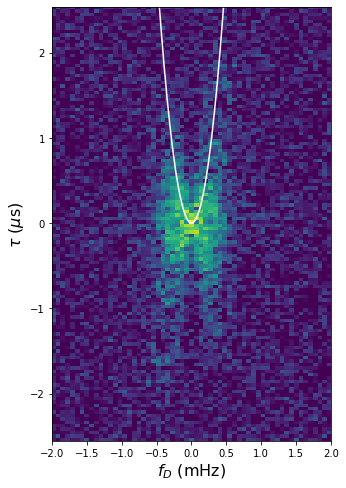

In [114]:
# zoom in plot to certain ftlim
# Overplot parabola of given curvature eta (units in mus / mHz^2 = s^3)
eta = 12.

xlim = 2.
ftplot = np.linspace(-xlim, xlim, 200)

# Corresponding veff/sqrt(deff) from eta
fref = np.mean(F)
lam = (c / fref).to(u.cm)

W = lam / np.sqrt(2*c*eta*u.s**3)
W = W.to(u.km/u.s/u.kpc**0.5)
print(W)

plt.figure(figsize=(5,8))

# Plot Secondary spectrum
plt.imshow(Sb.T, aspect='auto', vmin=slow, vmax=shigh, origin='lower',
           extent=[min(ft), max(ft), min(tau), max(tau)], interpolation='nearest',
          cmap='viridis')
plt.xlabel(r'$f_{D}$ (mHz)', fontsize=16)
plt.ylabel(r'$\tau$ ($\mu$s)', fontsize=16) 

plt.plot(ftplot, eta*ftplot**2, color='w')

if xlim:
    plt.xlim(-xlim, xlim)
plt.ylim(min(tau), max(tau))

/home/ramain/packages/FundiScintTutorial2023/normsspectools.py:24: RuntimeWarning: divide by zero encountered in true_divide
  curvaxis = tauref / (xgrid)**2.0


95.15480015283951 134.54250907999545
The best fit curvature is 95.15480015283951+-134.54250907999545
The best fit scaled effective velocity is 4.892943204826773 km / (kpc(1/2) s)+-3.459146855996332 km / (kpc(1/2) s)


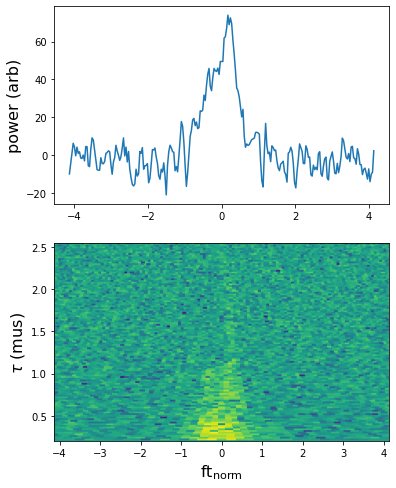

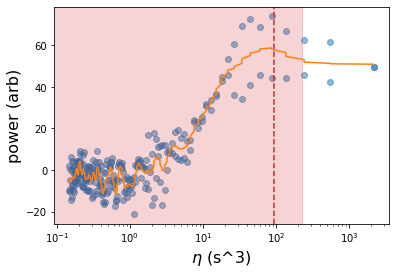

In [118]:
Ngrid = 2*len(ft)
taumin = 0.2
Sbg = np.log10(S)
Sbg = Sbg - np.mean(Sbg, axis=0)
Snorm, ftnormaxis, curvaxis = ns.norm_sspec(Sbg, ft, tau, Ngrid=Ngrid, taumin=taumin)
Sprof = Snorm.sum(1)

plt.figure(figsize=(6, 8))

plt.subplot(211)
plt.plot(ftnormaxis, Sprof)
plt.ylabel('power (arb)', fontsize=16)

plt.subplot(212)
plt.imshow(Snorm.T, origin='lower', aspect='auto',
          extent=[min(ftnormaxis), max(ftnormaxis), min(tau), max(tau)])
plt.ylim(taumin, max(tau))

plt.xlabel(r'ft$_{\rm norm}$', fontsize=16)
plt.ylabel(r'$\tau$ (mus)', fontsize=16)


ieta = np.argsort(curvaxis)
eta_ax = curvaxis[ieta]
I_eta = Sprof[ieta]
I_etasmooth = gaussian_filter(I_eta, 2)

plt.figure()
plt.scatter(eta_ax, I_eta, alpha=0.5)
plt.plot(eta_ax, I_etasmooth, color='tab:orange')

plt.xscale('log')
# Take lim around the peak, fit with e.g. a parabola to measure peak

plt.ylabel('power (arb)', fontsize=16)
plt.xlabel(r'$\eta$ (s^3)', fontsize=16)

imax = np.argmax(I_etasmooth)
etapeak = eta_ax[imax]
Ipeak = I_etasmooth[imax]
etarange = 0.3
fitrange = np.argwhere( (eta_ax > etarange*etapeak) & (eta_ax < etapeak/etarange) ).squeeze()
I_fit = I_eta[fitrange]
eta_fit = eta_ax[fitrange]

p0 = [etapeak, -Ipeak, Ipeak]

yfit, eta, eta_err = ns.fit_log_parabola(eta_fit, I_fit)
plt.axvline(eta, color='tab:red', linestyle='--')
plt.axvspan(eta-eta_err, eta+eta_err, color='tab:red', alpha=0.2)

print(eta, eta_err)
W = lam / np.sqrt(2*c*eta*u.s**3)
W = W.to(u.km/u.s/u.kpc**0.5)

Werr = lam / (2*np.sqrt(2*c)) * (eta*u.s**3)**(-3/2.) * eta_err*u.s**3
Werr = Werr.to(u.km/u.s/u.kpc**0.5)

print("The best fit curvature is {0}+-{1}".format(eta, eta_err))
print("The best fit scaled effective velocity is {0}+-{1}".format(W, Werr) )


# Fitting velocities

In [121]:
def arc_curvature_veff(params, ydata, weights, true_anomaly,
                  vearth_ra, vearth_dec, vfit=False, modelonly=False):
    """
    arc curvature model

        ydata: arc curvature (vfit=False), or 
               1 / sqrt(arc curvature) (when vfit=True)
    """

    # ensure dimensionality of arrays makes sense
    if hasattr(ydata,  "__len__"):
        ydata = ydata.squeeze()
        weights = weights.squeeze()
        true_anomaly = true_anomaly.squeeze()
        vearth_ra = vearth_ra.squeeze()
        vearth_dec = vearth_dec.squeeze()

    kmpkpc = 3.085677581e16

    # Other parameters in lower-case
    d = params['d']  # pulsar distance in kpc
    try:
        s = params['s']  # fractional screen distance
    except:
        d_s = params['d_s'] # screen distance in kpc
        s = 1 - d_s / d
    dkm = d * kmpkpc  # kms

    veff_ra, veff_dec, vp_ra, vp_dec = \
        effective_velocity_annual(params, true_anomaly,
                                  vearth_ra, vearth_dec)

    psi = params['psi'] * np.pi / 180  # anisotropy angle
    vism_psi = params['vism_psi']  # vism in direction of anisotropy
    #veff2 = (veff_ra*np.sin(psi) + veff_dec*np.cos(psi) - vism_psi)**2
    veff = (veff_ra*np.sin(psi) + veff_dec*np.cos(psi) - vism_psi)
    veff2 = veff**2 * np.sign(veff)

    # Calculate curvature model
    model = dkm * s * (1 - s)/veff2  # in 1/(km * Hz**2)

    # Convert to 1/(m * mHz**2) for beta in 1/m and fdop in mHz

    if weights is None:
        weights = np.ones(np.shape(ydata))

    kmHz_to_kmskpc = 175660968.387
    model = np.sign(veff) / np.sqrt(abs(model)) 
    model = np.abs(model) * kmHz_to_kmskpc
    #model = model * kmHz_to_kmskpc

    if modelonly:
        return model

    return ((ydata - model) * weights).astype('float')

In [112]:
def get_earth_velocity(mjds, raj, decj):
    """
    Calculates the component of Earth's velocity transverse to the line of
    sight, in RA and DEC
    """

    from astropy.time import Time
    from astropy.coordinates import get_body_barycentric_posvel, SkyCoord
    from astropy import units as u
    from astropy.constants import au

    coord = SkyCoord('{0} {1}'.format(raj, decj), unit=(u.hourangle, u.deg))
    rarad = coord.ra.value * np.pi/180
    decrad = coord.dec.value * np.pi/180

    vearth_ra = []
    vearth_dec = []
    for mjd in mjds:
        time = Time(mjd, format='mjd')
        pos_xyz, vel_xyz = get_body_barycentric_posvel('earth', time)

        vx = vel_xyz.x.value
        vy = vel_xyz.y.value
        vz = vel_xyz.z.value

        vearth_ra.append(- vx * np.sin(rarad) + vy * np.cos(rarad))
        vearth_dec.append(- vx * np.sin(decrad) * np.cos(rarad) -
                          vy * np.sin(decrad) * np.sin(rarad) +
                          vz * np.cos(decrad))

    # Convert from AU/d to km/s
    vearth_ra = vearth_ra * au/1e3/86400
    vearth_dec = vearth_dec * au/1e3/86400

    return vearth_ra.value.squeeze(), vearth_dec.value.squeeze()


def get_true_anomaly(mjds, pars):
    """
    Calculates true anomalies for an array of barycentric MJDs and a parameter
    dictionary
    """

    PB = pars['PB']
    T0 = pars['T0']
    ECC = pars['ECC']
    PBDOT = 0 if 'PBDOT' not in pars.keys() else pars['PBDOT']

    nb = 2*np.pi/PB

    # mean anomaly
    M = nb*((mjds - T0) - 0.5*(PBDOT/PB) * (mjds - T0)**2)
    M = M.squeeze()

    # eccentric anomaly
    if ECC < 1e-4:
        print('Assuming circular orbit for true anomaly calculation')
        E = M
    else:
        E = fsolve(lambda E: E - ECC*np.sin(E) - M, M)

    # true anomaly
    U = 2*np.arctan2(np.sqrt(1 + ECC) * np.sin(E/2),
                     np.sqrt(1 - ECC) * np.cos(E/2))  # true anomaly
    if hasattr(U,  "__len__"):
        U[np.argwhere(U < 0)] = U[np.argwhere(U < 0)] + 2*np.pi
        U = U.squeeze()
    elif U < 0:
        U += 2*np.pi

    return U


def effective_velocity_annual(params, true_anomaly, vearth_ra, vearth_dec,
                              mjd=None):
    """
    Effective velocity with annual and pulsar terms
        Note: Does NOT include IISM velocity, but returns veff in IISM frame
    """
    # Define some constants
    v_c = 299792.458  # km/s
    kmpkpc = 3.085677581e16
    secperyr = 86400*365.2425
    masrad = np.pi/(3600*180*1000)

    # tempo2 parameters from par file in capitals
    if 'PB' in params.keys():
        A1 = params['A1']  # projected semi-major axis in lt-s
        PB = params['PB']  # orbital period in days
        ECC = params['ECC']  # orbital eccentricity
        OM = params['OM'] * np.pi/180  # longitude of periastron rad
        if 'OMDOT' in params.keys():
            omega = OM + params['OMDOT']*np.pi/180*(mjd-params['T0'])/365.2425
        else:
            omega = OM
        # Note: fifth Keplerian param T0 used in true anomaly calculation
        if 'KIN' in params.keys():
            INC = params['KIN']*np.pi/180  # inclination
        elif 'COSI' in params.keys():
            INC = np.arccos(params['COSI'])
        elif 'SINI' in params.keys():
            INC = np.arcsin(params['SINI'])
        else:
            print('Warning: inclination parameter (KIN, COSI, or SINI) ' +
                  'not found')

        if 'sense' in params.keys():
            sense = params['sense']
            if sense < 0.5:  # KIN < 90
                if INC > np.pi/2:
                    INC = np.pi - INC
            if sense >= 0.5:  # KIN > 90
                if INC < np.pi/2:
                    INC = np.pi - INC

        KOM = params['KOM']*np.pi/180  # longitude ascending node

        # Calculate pulsar velocity aligned with the line of nodes (Vx) and
        #   perpendicular in the plane (Vy)
        vp_0 = (2 * np.pi * A1 * v_c) / (np.sin(INC) * PB * 86400 *
                                         np.sqrt(1 - ECC**2))
        vp_x = -vp_0 * (ECC * np.sin(omega) + np.sin(true_anomaly + omega))
        vp_y = vp_0 * np.cos(INC) * (ECC * np.cos(omega) + np.cos(true_anomaly
                                                                  + omega))
    else:
        vp_x = 0
        vp_y = 0
        KOM = 0

    if 'PMRA' in params.keys():
        PMRA = params['PMRA']  # proper motion in RA
        PMDEC = params['PMDEC']  # proper motion in DEC
    else:
        PMRA = 0
        PMDEC = 0

    # other parameters in lower-case
    s = params['s']  # fractional screen distance
    d = params['d']  # pulsar distance in kpc
    d = d * kmpkpc  # distance in km

    pmra_v = PMRA * masrad * d / secperyr
    pmdec_v = PMDEC * masrad * d / secperyr

    # Rotate pulsar velocity into RA/DEC
    vp_ra = np.sin(KOM) * vp_x + np.cos(KOM) * vp_y
    vp_dec = np.cos(KOM) * vp_x - np.sin(KOM) * vp_y

    # find total effective velocity in RA and DEC
    veff_ra = s * vearth_ra + (1 - s) * (vp_ra + pmra_v)
    veff_dec = s * vearth_dec + (1 - s) * (vp_dec + pmdec_v)

    return veff_ra, veff_dec, vp_ra, vp_dec



Getting Earth velocity
Getting true anomaly
Assuming circular orbit for true anomaly calculation
Doing mcmc posterior sample
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 500000
    # data points      = 25
    # variables        = 5
    chi-square         = 15.6536199
    reduced chi-square = 0.78268100
    Akaike info crit   = -1.70434071
    Bayesian info crit = 4.39003841
[[Variables]]
    RAJ:       1.835345 (fixed)
    DECJ:      1.122301 (fixed)
    A1:        32.34 (fixed)
    PB:        67.8 (fixed)
    ECC:       7.5e-05 (fixed)
    OM:        176.2 (fixed)
    T0:        54303.63 (fixed)
    PMRA:      4.9238 (fixed)
    PMDEC:    -3.9146 (fixed)
    d:         1.15 (fixed)
    s:         0.51526666 +/- 0.00798228 (1.55%) (init = 0.6)
    vism_psi:  5.15699006 +/- 1.13442214 (22.00%) (init = 8)
    psi:       67.5864350 +/- 4.62100431 (6.84%) (init = 60)
    KIN:       89.8387416 +/- 3.18772310 (3.55%) (init = 71.7)
    KOM:       20.6048494 +/- 5

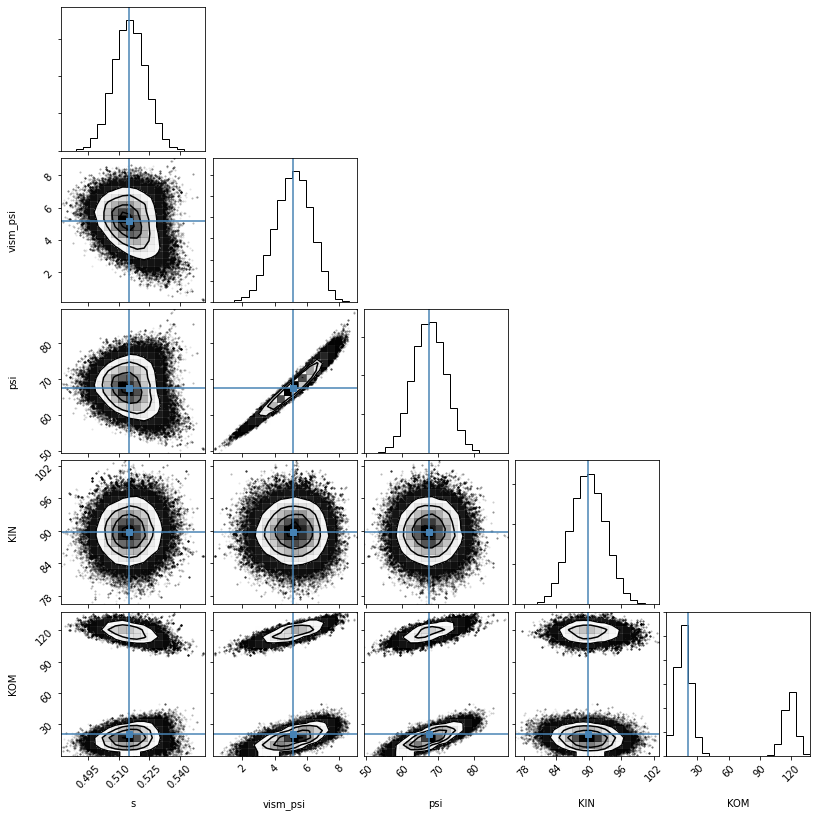

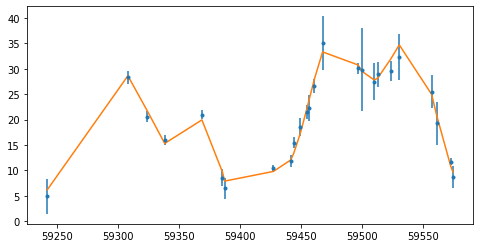

In [125]:
from lmfit import Parameters, fit_report, minimize
from lmfit import Minimizer
import lmfit 
import corner

y = np.copy(Ws[goodargs])
yerr = np.copy(Werrs[goodargs])
mjd = mjds[goodargs]

isort = np.argsort(mjd)
mjd = mjd[isort]
y = y[isort]
yerr = yerr[isort]

vfit = 1

params = Parameters()

# Pulsar sky position
params.add('RAJ', value=1.835345, vary=False)
params.add('DECJ', value=1.122301, vary=False)

# Orbital Parameters
params.add('A1', value=32.34, vary=False)
params.add('PB', value=67.8, vary=False)
params.add('ECC', value=7.5e-5, vary=False)
params.add('OM', value=176.2, vary=False)
params.add('T0', value=54303.6340, vary=False)

params.add('PMRA', value=4.9238, vary=False)
params.add('PMDEC', value=-3.9146, vary=False)
params.add('d', value=1.15, vary=False)

# Unknown parameters of screen
params.add('s', value=0.6, vary=True, min=0.0, max=1.0)  
params.add('vism_psi', value=8.0, vary=True)
params.add('psi', value=60., vary=True, min=0, max=180)

params.add('KIN', value=71.7, vary=True, min=0, max=180)
params.add('KOM', value=89.0,
           vary=True, min=0, max=360)

print('Getting Earth velocity')
vearth_ra, vearth_dec = get_earth_velocity(mjd, params['RAJ'].value, params['DECJ'].value)

print('Getting true anomaly')
U = get_true_anomaly(mjd, params)

veff_ra, veff_dec, vp_ra, vp_dec = \
    effective_velocity_annual(params, U,
                              vearth_ra, vearth_dec)


func = Minimizer(arc_curvature_veff, params,
                 fcn_args=(y, 1/yerr, U,
                           vearth_ra, vearth_dec, 
                           vfit))

print('Doing mcmc posterior sample')    
mcmc_results = func.emcee(steps=5000, burn=1000, nwalkers=100)
mcmc_unchanged = mcmc_results

lmfit.report_fit(mcmc_results)

truths = []
for var in mcmc_results.var_names:
    truths.append(mcmc_results.params[var].value)
labels = mcmc_results.var_names

corner.corner(mcmc_results.flatchain,
              labels=labels,
              truths=truths)
lmfit.report_fit(mcmc_results)
#plt.savefig('{0}_mcmc2013_{1}.pdf'.format(psrname, alabel))

"""
Now plot the fit
"""
curvature_model = arc_curvature_veff(mcmc_results.params, y, yerr, U, vearth_ra, vearth_dec,
                                vfit, modelonly=True)                              


plt.figure(figsize=(8,4))
plt.errorbar(mjd, y, yerr, fmt='.')
plt.plot(mjd, curvature_model)
plt.show()     